<a href="https://colab.research.google.com/github/Veleces/Project/blob/main/Deep%20Learning%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction Model
Herramienta diseñada para pronosticar el comportamiento de un intrumento bursátil (Stock,ETF) para los próximos N días, mediante el uso de una red neuronal recurrente llamada Long Short Term Memory (LSTM).

# Instalación de librerías

In [ ]:
# Instalamos las librerías necesarias

!pip install -q yfinance
!pip install mplfinance
!pip install --upgrade mplfinance

# Instalamos la librería de Keras Tuner para el ajuste de nuestros hiperparámetros

!pip install -U keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importamos las librerías a utilizar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# Para leer los datos del ticker  

from pandas_datareader.data import DataReader
import yfinance as yf
import mplfinance as mpf
from pandas_datareader import data as pdr

yf.pdr_override()

# Para las fechas 

import datetime
from datetime import datetime
from datetime import datetime, timedelta


# Recolección de Datos

In [ ]:
# Creamos las variables globales que nos permitirán personalizar nuestro modelo

# Ticker de nuestra acción (nombre con el que cotiza en bolsa)

ticker = "NVDA" 

# Fecha inicial con la cual empezaremos a recabar nuestros datos, la fecha inicial 
# será "1900-01-01" para no poner la fecha inicial específica

first_date = "1900-01-01"

# Fecha hasta la cual recabaremos nuestros datos

today = "2023-04-30"

# Rango de días que queremos pronosticar 

prediction_days = 10

# Porcentaje de datos que vamos a entrenar

Percentage = 0.85


In [ ]:
# Recolectamos nuestros datos históricos del ticker 

stock = yf.download(ticker, first_date, today)

# Utilizamos el na.omit para omitir los NA al recolectar nuestros datos

stock.dropna(inplace = True)

# Comprobamos que no tengas ningún valor NA

stock.isna().sum()


[*********************100%***********************]  1 of 1 completed


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
# Mostranos los datos recolectados

stock


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376358,271468800
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415786,51048000
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383527,34320000
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382332,24436800
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381137,22752000
...,...,...,...,...,...,...
2023-04-24,270.130005,273.660004,266.709991,270.420013,270.420013,33928200
2023-04-25,270.779999,272.470001,262.250000,262.410004,262.410004,37852700
2023-04-26,270.019989,273.299988,267.049988,269.559998,269.559998,40633700


# Análisis exploratorio de datos

# Descripción de Datos

In [ ]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6107 entries, 1999-01-22 to 2023-04-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6107 non-null   float64
 1   High       6107 non-null   float64
 2   Low        6107 non-null   float64
 3   Close      6107 non-null   float64
 4   Adj Close  6107 non-null   float64
 5   Volume     6107 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 334.0 KB


In [ ]:
stock.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6107.000000,6107.000000,6107.000000,6107.000000,6107.000000,6.107000e+03
mean,31.453661,32.057422,30.829513,31.470503,31.210371,6.133556e+07
std,60.735876,61.966718,59.436377,60.756653,60.759673,4.404600e+07
min,0.348958,0.355469,0.333333,0.341146,0.313034,1.968000e+06
25%,2.674739,2.750000,2.601667,2.675833,2.455335,3.440220e+07
50%,4.295000,4.385000,4.220833,4.305000,3.968602,5.145720e+07
75%,27.066251,27.455000,26.653749,27.094999,26.730668,7.460270e+07
max,335.170013,346.470001,320.359985,333.760010,333.350739,9.230856e+08


# Visualización de Datos

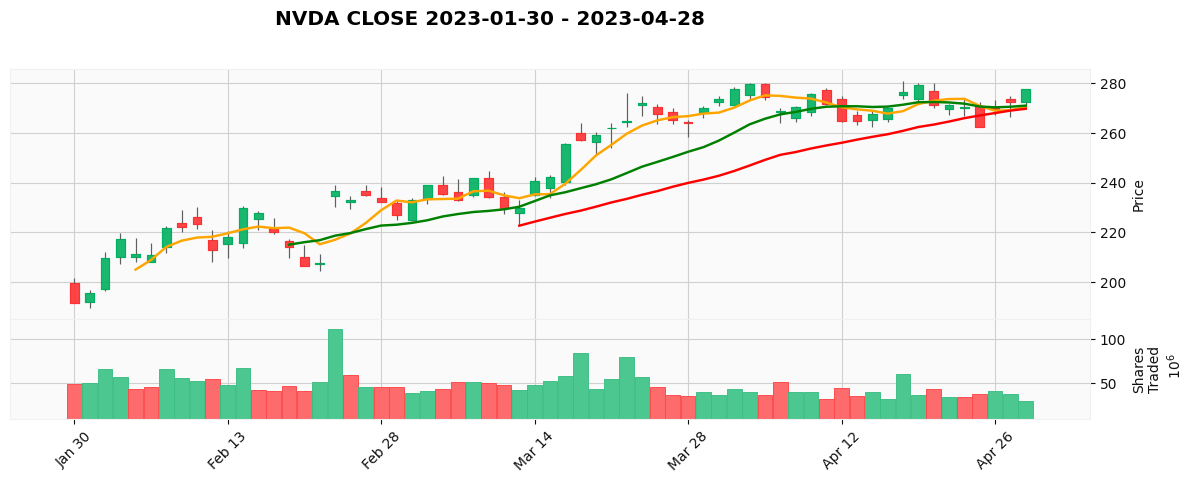

In [ ]:
# Gráficamos nuestros datos (Open, High, Low, Volume y Close)

# Creamos una nueva columna de fechas para mplfinance

stock["Date"] = stock.index

# Definimos los rangos de fechas a graficar

start_date_plt = (datetime.strptime(today, '%Y-%m-%d') - timedelta(days=90)).strftime('%Y-%m-%d')
end_date_plt = stock['Date'][-1].strftime('%Y-%m-%d')

# Seleccionamos el período de tiempo deseado

dates = stock[start_date_plt:end_date_plt]

# Graficamos los datos

mpf.plot(dates, type = "candle", volume = True, mav = [5, 15, 30], 
         mavcolors = ["orange", "green", "red"], style = "yahoo",
         title = f"{ticker} CLOSE {start_date_plt} - {end_date_plt}",
         ylabel = "Price", ylabel_lower = "Shares\nTraded",
         figsize=(15, 5))


<ipython-input-134-56761bea529a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_period [column_name] = selected_period ['Adj Close'].rolling(ma).mean()
<ipython-input-134-56761bea529a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_period [column_name] = selected_period ['Adj Close'].rolling(ma).mean()
<ipython-input-134-56761bea529a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

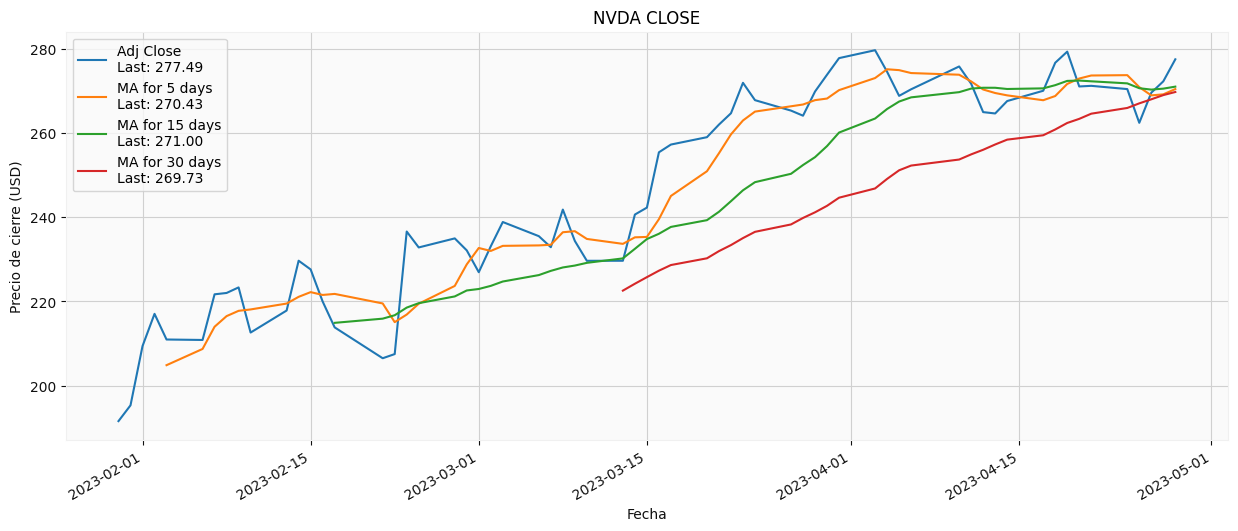

In [ ]:
# Gráficamos las Medias Móviles con más detalle

# Seleccionamos el período de tiempo deseado

selected_period = stock[start_date_plt : end_date_plt]

# Calculamos las Medias Móviles

ma_day = [5, 15, 30]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    selected_period [column_name] = selected_period ['Adj Close'].rolling(ma).mean()

fig, ax = plt.subplots(figsize=(15, 6))

selected_period [['Adj Close', 'MA for 5 days', 'MA for 15 days', 'MA for 30 days']].plot(ax=ax)

ax.set_title(f"{ticker} CLOSE")
ax.legend(labels=['Adj Close\nLast: {:.2f}'.format(stock['Close'][-1]), 
                  'MA for 5 days\nLast: {:.2f}'.format(selected_period ['MA for 5 days'][-1]), 
                  'MA for 15 days\nLast: {:.2f}'.format(selected_period ['MA for 15 days'][-1]), 
                  'MA for 30 days\nLast: {:.2f}'.format(selected_period ['MA for 30 days'][-1])])

ax.set_xlabel('Fecha')
ax.set_ylabel('Precio de cierre (USD)')

plt.show()


<ipython-input-135-51830bb80c84>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(stock.corr(), vmin=-1, vmax=1, square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .8}, cmap='Blues')


<Axes: >

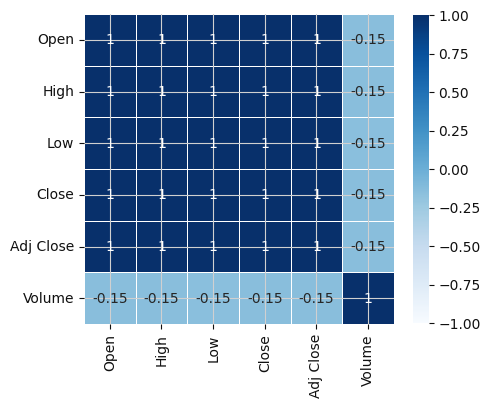

In [ ]:
# Visualizamos la matriz de correlación usando un heatmap

f, ax = plt.subplots(figsize=(5, 5))

sns.heatmap(stock.corr(), vmin=-1, vmax=1, square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .8}, cmap='Blues')


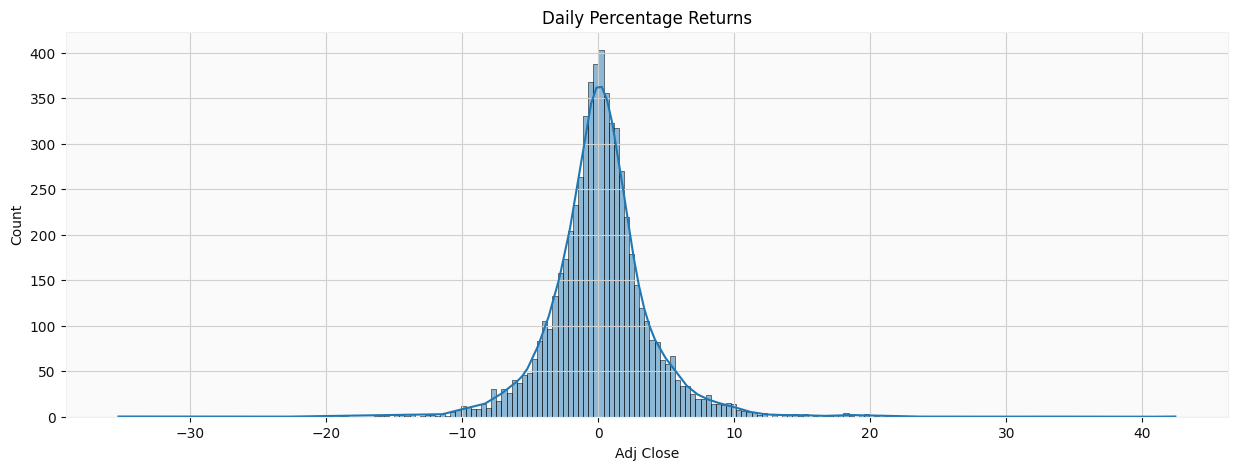

In [ ]:
# Gráficamos la distribución de los retornos porcentuales diarios

# Calculamos los retornos porcentuales diarios

daily_return = stock['Adj Close'].pct_change() * 100
daily_return.dropna(inplace=True)

# Creamos el histograma de los retornos porcentuales diarios

fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(daily_return, kde=True)
plt.title('Daily Percentage Returns')
plt.show()


[*********************100%***********************]  1 of 1 completed


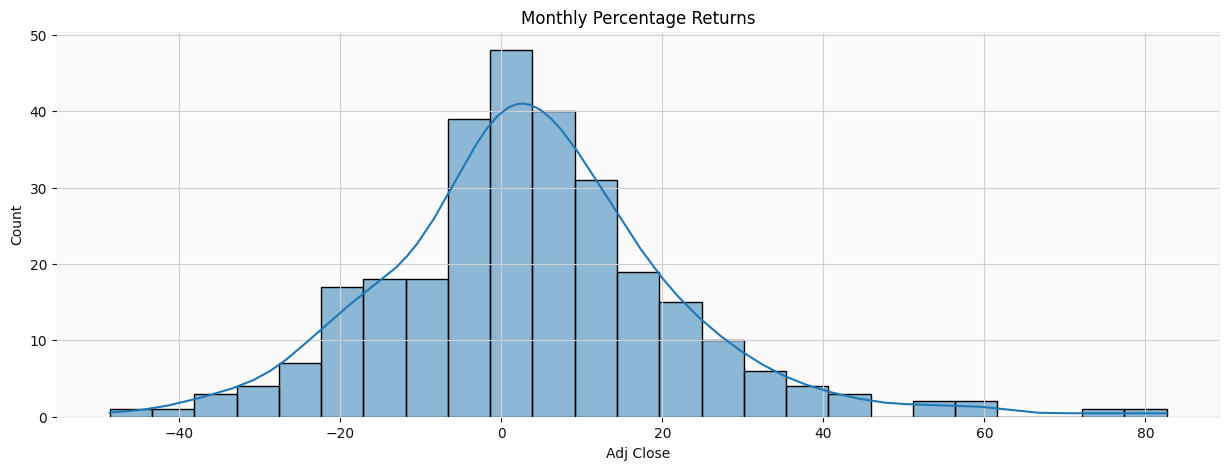

In [ ]:
# Gráficamos la distribución de los retornos porcentuales mensuales

# Obtenemos los datos de manera mensual

monthly_stock = yf.download(ticker, start=first_date, end=today, interval='1mo')

# Calculamos los retornos porcentuales mensuales

monthly_return = monthly_stock['Adj Close'].pct_change() * 100
monthly_return.dropna(inplace=True)

# Creamos el histograma de los retornos porcentuales mensuales

fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(monthly_return, kde=True)
plt.title('Monthly Percentage Returns')
plt.show()


# Ingeniería / selección de características más limpieza de datos
Vamos a tomar la columna Adjusted Close ya que viene siendo la misma que Close, pero esta columna nos refleja la informaición actualizada después de los splits.

In [ ]:
def add_days(data, prediction_days):

    import pandas as pd
    import numpy as np
    import datetime

    # Obtener el último índice de data
    last_date = data.index[-1]

    # Inicializar el contador de días hábiles
    n_days = 0

    # Lista para almacenar los nuevos índices
    new_index = []

    # Repetir hasta que se hayan obtenido los n días hábiles adicionales
    while n_days < prediction_days:
        # Sumar un día al último índice de data
        new_date = last_date + datetime.timedelta(days=1)

        # Verificar si es fin de semana (sábado o domingo)
        if new_date.weekday() < 5:
            # Si es día hábil, agregar el índice a la lista de nuevos índices
            new_index.append(new_date)
            # Incrementar el contador de días hábiles
            n_days += 1

        # Actualizar el último índice
        last_date = new_date

    # Crear un dataframe con los nuevos índices y valores NaN
    new_data = pd.DataFrame(index=new_index, columns=data.columns)
    new_data = new_data.fillna(np.nan)

    # Concatenar el nuevo dataframe con data
    data = pd.concat([data, new_data])
    
    return data


In [ ]:
# Seleccionar sólo la columna "Adjusted Close" para el análisis

data = stock.filter(['Adj Close'])

data


,Adj Close
Date,
1999-01-22,0.376358
1999-01-25,0.415786
1999-01-26,0.383527
1999-01-27,0.382332
1999-01-28,0.381138
...,...
2023-04-24,270.420013
2023-04-25,262.410004
2023-04-26,269.559998


# Modelo Deep learning LSTM
Este modelo de redes neuronales recurrentes (RNN) con celdas LSTM (long short-term memory) puede ser útil para la predicción de precios de acciones debido a que puede capturar patrones y relaciones complejas en series de tiempo.

En el caso específico de la predicción de precios de acciones, el comportamiento del precio de las acciones puede estar influenciado por muchos factores como: los reportes de la compañia, la situación económica del país o el sector al que pertenece la empresa. Estos factores pueden cambiar con el tiempo y ser difíciles de modelar con modelos estadísticos tradicionales. 

Un modelo de redes neuronales recurrentes como LSTM, puede capturar estos patrones y relaciones complejas a medida que se presentan nuevos datos, lo que puede ayudarnos a realizar predicciones del precio de la acción en el futuro.

# Métrica de Evaluación RMSE
Este modelo LSTM utilizado para predecir los precios de las acciones se entrena con la función de pérdida "mean_squared_error" y la métrica de evaluación que utiliza para medir el rendimiento del modelo es el RMSE (Root Mean Squared Error).

La métrica RMSE es adecuada para evaluar el rendimiento del modelo ya que su objetivo principal es predecir el precio de las acciones. Por lo tanto, es importante que el modelo pueda hacer predicciones precisas y cercanas a los valores reales. Un RMSE bajo indicaría que el modelo está haciendo predicciones correctas y puede ser utilizado para tomar decisiones de inversión informadas, sin embargo, también hay que tener en cuenta que no debemos tener un RMSE demasiado bajo, ya que lo que buscamos con este modelo no es predecir el precio como tal, sino predecir la tendencia del precio a n días (alza o baja).

In [ ]:
# Importamos las librerías necesarias para este modelo

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Importamos Keras Tunner para el ajuste de hiperparámetros

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters


In [ ]:
# Convertimos el dataframe en un arreglo de numpy

dataset = data.values

# Obtenemos el número de filas para entrenar el modelo

training_data_len = int(np.ceil(Percentage * len(dataset)))

# Normalizar los datos

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


In [ ]:
# Creamos los datos de entrenamiento y prueba

days = prediction_days + 55

train_data = scaled_data[0 : training_data_len, : ]
x_train = []
y_train = []

for i in range(days, len(train_data)):
    x_train.append(train_data[i - days : i , 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Crear los datos de prueba

test_data = scaled_data[training_data_len - days:, :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(days, len(test_data)):
    x_test.append(test_data[i - days : i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


# Ajuste de Hiperparámetros con Keras Tunner

In [ ]:
# Definimos una función que construya el modelo LSTM y compile con los hiperparámetros a sintonizar:

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=512, step=32),
                   return_sequences=True,
                   input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=512, step=32),
                   return_sequences=False))
    model.add(Dense(units=hp.Int('units', min_value=25, max_value=512, step=32)))
    model.add(Dense(units=1))
    model.compile(optimizer=hp.Choice('optimizer', ['adam']), #, 'rmsprop'
                  loss='mean_squared_error')
    return model


In [ ]:
# Definimos una instancia del sintonizador:

tuner = RandomSearch(build_model,
                     objective = 'val_loss',
                     max_trials = 15,
                     executions_per_trial = 5,
                     directory = 'my_dir',
                     project_name = 'stock_prediction')


In [ ]:
# Ejecutamos la búsqueda de hiperparámetros:

tuner.search(x_train, y_train, batch_size = 1, epochs = 1, validation_data = (x_test, y_test))


In [ ]:
# Mostramos los mejores hiperparámetros encontrados:

best_hp = tuner.get_best_hyperparameters(num_trials = 1)[0]


In [ ]:
# Entrenamos el modelo con los mejores hiperparámetros encontrados:

model = tuner.hypermodel.build(best_hp)
model.fit(x_train, y_train, batch_size = 1, epochs = 3, validation_data = (x_test, y_test))


Epoch 1/3
5126/5126 [==============================] - 63s 11ms/step - loss: 2.3167e-04 - val_loss: 29174.5117
Epoch 2/3
5126/5126 [==============================] - 49s 10ms/step - loss: 3.0386e-05 - val_loss: 29195.6836
Epoch 3/3
5126/5126 [==============================] - 58s 11ms/step - loss: 2.3984e-05 - val_loss: 29179.0859


In [ ]:
# Realizamos la predicción

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Calculamos el RMSE

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('Root Mean Squared Error:', rmse)


29/29 [==============================] - 1s 7ms/step
Root Mean Squared Error: 7.695534437942299


In [ ]:
# Generamos un Data Frame con los resultados

train = data[:training_data_len] 
valid = data[training_data_len:] 
valid['Predictions'] = predictions 
valid.tail(10)


<ipython-input-60-4e5480395422>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


,Adj Close,Predictions
Date,,
2023-04-17,270.019989,256.200775
2023-04-18,276.670013,259.486542
2023-04-19,279.309998,265.390045
2023-04-20,271.040009,268.316162
2023-04-21,271.190002,261.710693
2023-04-24,270.420013,259.514893
2023-04-25,262.410004,258.794617
2023-04-26,269.559998,253.022003
2023-04-27,272.260010,257.541656


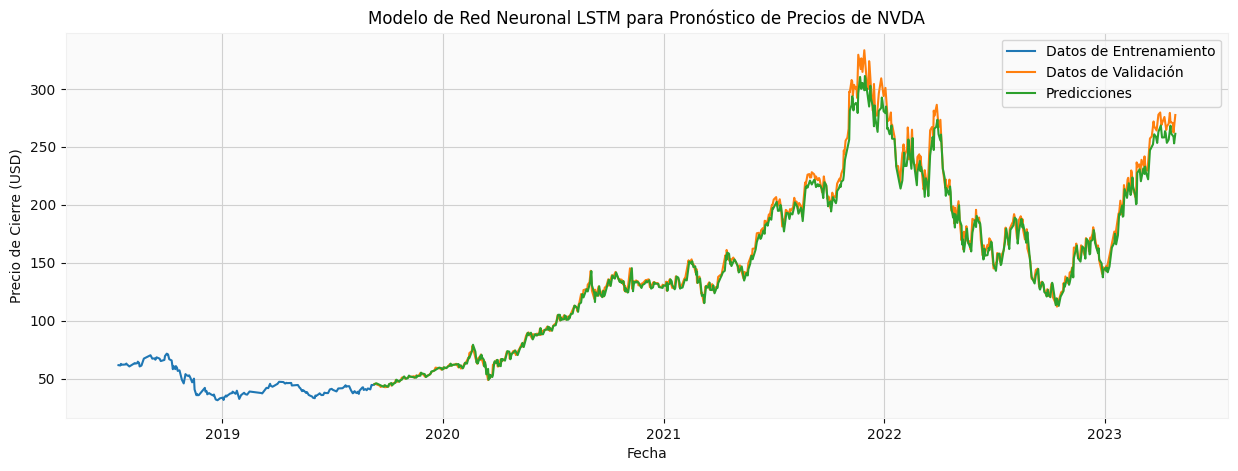

In [ ]:
# Graficamos nuestra prediciciones 

plt.figure(figsize=(15,5))
plt.title(f"Modelo de Red Neuronal LSTM para Pronóstico de Precios de {ticker}")
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.plot(train['Adj Close'][4900:])
plt.plot(valid[['Adj Close', 'Predictions']][0:])
plt.legend(['Datos de Entrenamiento', 'Datos de Validación', 'Predicciones'])
plt.show()


# Creamos nuestro pronóstico para los próximos n días

In [ ]:
# Data Frame

data = add_days(data, prediction_days)
data


,Adj Close
1999-01-22,0.376358
1999-01-25,0.415786
1999-01-26,0.383527
1999-01-27,0.382332
1999-01-28,0.381138
...,...
2023-05-08,NaN
2023-05-09,NaN
2023-05-10,NaN
2023-05-11,NaN


In [ ]:
# Seleccionar la columna de interés

data = stock[["Adj Close"]]

# Normalizar los datos

scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(data)

# Definir la longitud de la secuencia de entrada

n_input = prediction_days + 85

# Separar los datos en conjunto de entrenamiento y conjunto de prueba

train_data_norm, test_data_norm = train_test_split(data_norm, test_size=0.10, shuffle=False)

# Obtener las predicciones para los próximos n días

x_input = test_data_norm[-n_input:].reshape((1, n_input, 1))
prediccion_ndias = model.predict(x_input, verbose=0)

# Invertir la normalización de los datos

prediccion_ndias = scaler.inverse_transform(prediccion_ndias.reshape(-1,1))

# Obtener los datos del rango "2023-05-08 : 2023-05-12"

prediccion_rango = scaler.inverse_transform(test_data_norm[-n_input:])[-prediction_days:]
prediccion_rango = np.append(prediccion_rango, prediccion_ndias)

print(f'La predicción para los próximos {prediction_days} días es: {prediccion_ndias}')
print(f'Los valores del rango "2023-05-08 : 2023-05-12" son: {prediccion_rango}')


La predicción para los próximos 10 días es: [[266.51398]]
Los valores del rango "2023-05-08 : 2023-05-12" son: [270.01998901 276.67001343 279.30999756 271.04000854 271.19000244
 270.42001343 262.41000366 269.55999756 272.26000977 277.48999023
 266.51397705]


In [ ]:
# Data Frame 

data = add_days(data, prediction_days)


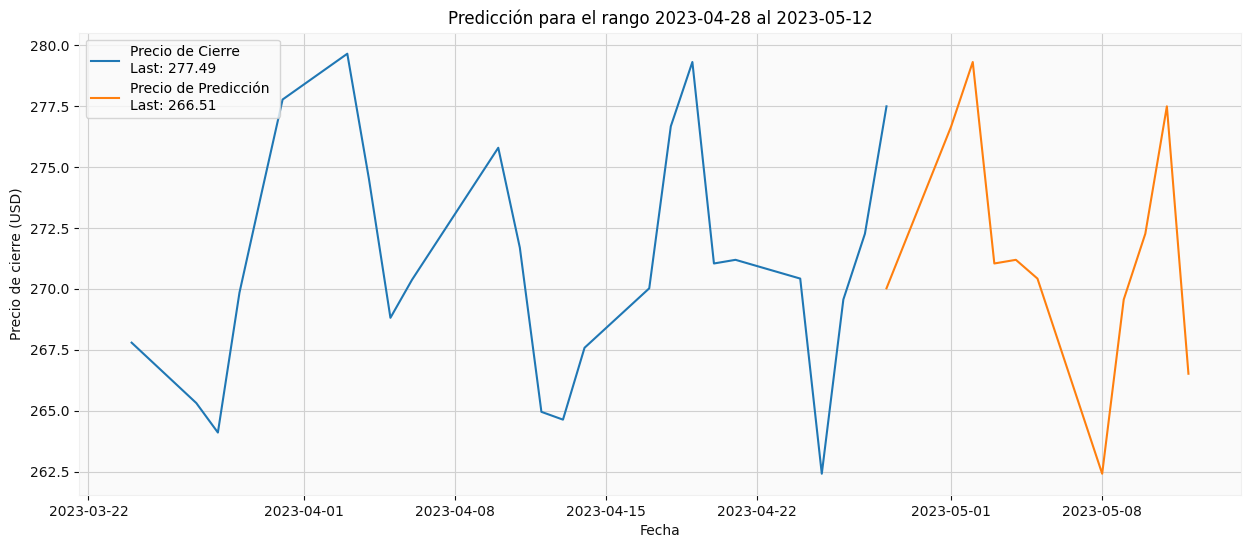

In [ ]:
# Obtener las fechas correspondientes al rango

fechas = data.index[ - (prediction_days + 1):]

# Crear una figura con varios ejes

fig, axs = plt.subplots(figsize=(15, 6))

# Graficar los valores de predicción en el segundo eje

axs.plot(data.index[-35:], data['Adj Close'][-35:], label=f"Precio de Cierre \nLast: {stock['Adj Close'][-1].round(2)}") 
axs.plot(fechas, prediccion_rango, label = f'Precio de Predicción \nLast: {prediccion_rango[-1].round(2)}')
axs.legend()
axs.set_title(f'Predicción para el rango {fechas[0].date().strftime("%Y-%m-%d")} al {fechas[-1].date().strftime("%Y-%m-%d")}')
axs.set_xlabel('Fecha')
axs.set_ylabel('Precio de cierre (USD)')

# Mostrar la figura
plt.show()


# Comparación pronóstico contra comportamiento real

In [ ]:
# Recolectamos nuestros datos históricos del ticker 

import datetime

updt_stock = yf.download(ticker, first_date, datetime.date.today() + datetime.timedelta(days=1))

# Utilizamos el na.omit para omitir los NA al recolectar nuestros datos

stock.dropna(inplace = True)

# Comprobamos que no tengas ningún valor NA

stock.isna().sum()


[*********************100%***********************]  1 of 1 completed


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Date         0
dtype: int64

In [ ]:
# Visualizamos nuestros datos actualizados al día de hoy

updt_stock


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376358,271468800
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415786,51048000
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383527,34320000
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382332,24436800
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381137,22752000
...,...,...,...,...,...,...
2023-05-08,285.220001,292.200012,283.500000,291.510010,291.510010,34497900
2023-05-09,288.989990,289.730011,284.500000,285.709991,285.709991,31486900
2023-05-10,290.049988,291.130005,284.609985,288.850006,288.850006,36935000


In [ ]:
# Data Frame 

data = add_days(data, prediction_days)


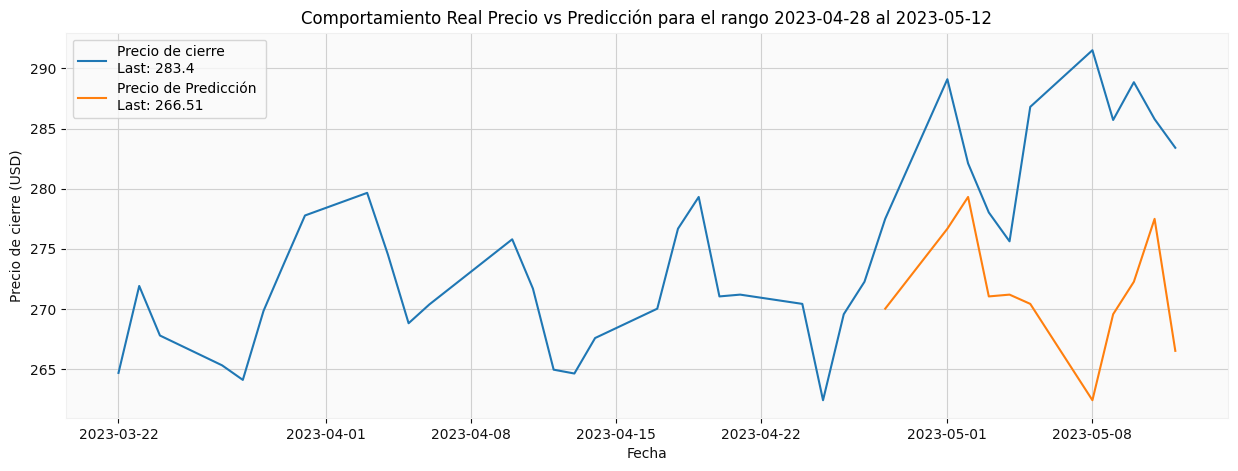

In [ ]:
less_days = 6080

fechas = updt_stock.index[ - (prediction_days + 1) : ]

fig, axs = plt.subplots(figsize=(15, 5))

# Graficar la columna "Adj Close"
plt.plot(updt_stock.index[less_days:], updt_stock['Adj Close'][less_days:], label=f"Precio de cierre \nLast: {updt_stock['Adj Close'][-1].round(2)}")

# Agregar etiquetas de ejes y título
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre ajustado (USD)')
plt.title('Gráfico de precios de cierre ajustado')

#axs.plot(data.index[less_days:], data['Adj Close'][less_days:], label='Precio de cierre')
axs.plot(fechas, prediccion_rango, label=f'Precio de Predicción \nLast: {prediccion_rango[-1].round(2)}')
axs.legend()
axs.set_title(f'Comportamiento Real Precio vs Predicción para el rango {fechas[0].date().strftime("%Y-%m-%d")} al {fechas[-1].date().strftime("%Y-%m-%d")}')
axs.set_xlabel('Fecha')
axs.set_ylabel('Precio de cierre (USD)')


# Mostrar la figura
plt.show()


In [ ]:
# Calculamos el RMSE

# Obtenemos los datos reales de Adjusted Close hata la fecha de hoy

real_adj_close = np.array(updt_stock['Adj Close'][-(prediction_days + 1):])

rmse = np.sqrt(np.mean(((prediccion_rango - real_adj_close) ** 2)))
print('Root Mean Squared Error:', rmse)


Root Mean Squared Error: 14.433108244764448


# Conclusión
Anteriormente contruí un modelo Stock Price Prediction con Random Forest en R, el modelo requiere más variables para tener un mejor desempeño, ya que traza el movimiento del precio de manera contraria a como suele comportarse el precio real de la acción, en general pronostica mejor los precios de ETFs que las acciones. Suele funcionar de manera rápida, incluso con acciones que tienen muchos datos históricos.

Este modelo con LSTM suele tener un desempeño mejor en el pronostico del precio, de igual manera podemos mejorar más este modelo añadiendo más variables como el volumen de compra y venta, noticas, reportes de la compañia, etc. La desventaha de este modelo radica en que es tardado ejecutar los cálculos si no contamos con un equipo de cómputo potente.

